The idea behind this project is to decide whether or not regression algorytms are appropriate for predicting Covid-19 cases. Predictions will be carried out on both on local country data (in this case Belgium) and global data.

In [ ]:
pip install covid19dh

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from covid19dh import covid19

**Analyzing local data for country: Belgium**

In [ ]:
covid_belgium, src = covid19("BEL") 

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


In [ ]:
covid_belgium.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g

Checking how many unique values each column has and whether it is useful for prediction.

In [ ]:
for col in covid_belgium.columns:
    temp = covid_belgium[col].unique()
    print(col,len(temp), (temp if len(temp) == 1 else ""))


id 1 ['22e14074']
date 835 
confirmed 797 
deaths 781 
recovered 222 
tests 797 
vaccines 493 
people_vaccinated 487 
people_fully_vaccinated 487 
hosp 686 
icu 510 
vent 406 
school_closing 6 
workplace_closing 6 
cancel_events 6 
gatherings_restrictions 6 
transport_closing 3 
stay_home_restrictions 6 
internal_movement_restrictions 5 
international_movement_restrictions 5 
information_campaigns 4 
testing_policy 5 
contact_tracing 4 
facial_coverings 7 
vaccination_policy 7 
elderly_people_protection 4 
government_response_index 55 
stringency_index 31 
containment_health_index 48 
economic_support_index 7 
administrative_area_level 1 [1]
administrative_area_level_1 1 ['Belgium']
administrative_area_level_2 1 [nan]
administrative_area_level_3 1 [nan]
latitude 1 [50.8333]
longitude 1 [4.]
population 1 [11433256.]
iso_alpha_3 1 ['BEL']
iso_alpha_2 1 ['BE']
iso_numeric 1 [56.]
iso_currency 1 ['EUR']
key_local 1 [nan]
key_google_mobility 1 ['ChIJl5fz7WR9wUcR8g_mObTy60c']
key_apple_mobil

Deleting several columns, that are listed below, from the dataset. Deleted columns are either useless for prediction or contain only one value. 

id,
administrative_area_level,
administrative_area_level_1,
administrative_area_level_2,
administrative_area_level_3,
latitude,
longitude,
population,
iso_alpha_3,
iso_alpha_2,
iso_numeric,
iso_currency,
key_local,
key_google_mobility,
key_apple_mobility,
key_jhu_csse,
key_nuts,
key_gadm

In [ ]:
covid_belgium = covid_belgium.drop(columns = ['id', 'administrative_area_level', 'administrative_area_level_1', 'administrative_area_level_2', 'administrative_area_level_3', 'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2', 'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm'])

Column 'recovered' is not useful for prediction, as the amount of people who have healed has no influence on the amount of Covid-19 cases and deaths it caused.

In [ ]:
covid_belgium = covid_belgium.drop(columns = ['recovered'])

Checking the null values in each column, in order to find the best way to fill the gaps.

In [ ]:
for col in covid_belgium.columns:
    print(col,covid_belgium[col].isnull().sum())

date 0
confirmed 39
deaths 55
tests 39
vaccines 343
people_vaccinated 343
people_fully_vaccinated 343
hosp 53
icu 53
vent 53
school_closing 6
workplace_closing 6
cancel_events 6
gatherings_restrictions 6
transport_closing 6
stay_home_restrictions 6
internal_movement_restrictions 6
international_movement_restrictions 6
information_campaigns 6
testing_policy 6
contact_tracing 6
facial_coverings 6
vaccination_policy 6
elderly_people_protection 6
government_response_index 6
stringency_index 6
containment_health_index 6
economic_support_index 6


Deleting records where columns 'deaths' and 'confirmed' contain null values, because approximation of values that are going to be predicted will cause the model to perform worse.

In [ ]:
covid_belgium = covid_belgium.dropna(subset=['confirmed', 'deaths'])

Creating a function that will fill the gaps based on average value or copying value of its neighbour.

In [ ]:
def fill_nan(data):
    length = len(data)
    for i,row in enumerate(data):
        if np.isnan(row):
          if i > 0 and not np.isnan(data[i-1]):
            data[i] = data[i-1]
          else:
            for j in range(i,length):
              if not np.isnan(data[j]):
                data[i] = data[j]
                break
    return data    

Filling empty rows except for columns 'vaccines','people_vaccinated' and 'people_fully_vaccinated' - much of the data predates the discovery of vaccines.

In [ ]:
covid_belgium.reset_index(drop=True, inplace=True)

In [ ]:
for column in covid_belgium.columns.difference(['vaccines','people_vaccinated','people_fully_vaccinated','date']):
      covid_belgium[column] = fill_nan(covid_belgium[column])

      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Deleting records where column 'vaccines' has no value. Vaccines are an important factor for predicting the amount of Covid-19 cases.

In [ ]:
cb_after_vac = covid_belgium[covid_belgium['vaccines'].notnull()]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cb_after_vac[cb_after_vac.columns.difference(['confirmed', 'deaths'])],cb_after_vac[['confirmed', 'deaths']],test_size=0.3,shuffle=False)

**Predicting the amount of confirmed cases for local data using linear regression**

In [ ]:
confirmed_scores = []
for independent_column in x_train.columns.difference(['date']):
    print(independent_column,end=' ')
    LR = LinearRegression()
    LR.fit(x_train[[independent_column]], y_train[['confirmed']])
    pred = LR.predict(x_test[[independent_column]])
    confirmed_scores.append([independent_column,'confirmed',r2_score(y_test[['confirmed']],pred),mean_absolute_percentage_error(y_test[['confirmed']],pred)])

cancel_events contact_tracing containment_health_index economic_support_index elderly_people_protection facial_coverings gatherings_restrictions government_response_index hosp icu information_campaigns internal_movement_restrictions international_movement_restrictions people_fully_vaccinated people_vaccinated school_closing stay_home_restrictions stringency_index testing_policy tests transport_closing vaccination_policy vaccines vent workplace_closing 

Choosing independent variables that perform the best, based on their R2 score.

In [ ]:
scores = pd.DataFrame(confirmed_scores,columns=['Independent column','Dependent column','R2','MAPE'])
top_5_confirmed_scores = scores.sort_values(by=["R2"],ascending=False).head(5)
print(top_5_confirmed_scores)

           Independent column Dependent column        R2      MAPE
3      economic_support_index        confirmed -1.531207  0.322587
19                      tests        confirmed -3.067948  0.390191
7   government_response_index        confirmed -4.089337  0.488714
22                   vaccines        confirmed -4.869337  0.480518
17           stringency_index        confirmed -5.928984  0.560343


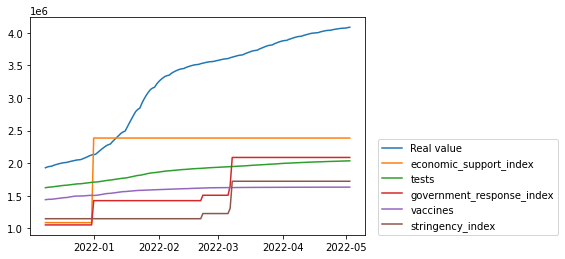

In [ ]:
plt.plot(x_test[['date']], y_test[['confirmed']], label='Real value')
for col in top_5_confirmed_scores['Independent column']:
  LR = LinearRegression()
  LR.fit(x_train[[col]], y_train[['confirmed']])
  pred = LR.predict(x_test[[col]])
  plt.plot(x_test[['date']], pred, label=col)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

Based on the plot, but also on their R2 and MAPE values, it is clear, that none of the independent values are appropriate for use in linear regression.

**Predicting the amount of deaths for local data using linear regression**

In [ ]:
deaths_scores = []
for independent_column in x_train.columns.difference(['date']):
    print(independent_column,end=' ')
    LR = LinearRegression()
    LR.fit(x_train[[independent_column]], y_train[['deaths']])
    pred = LR.predict(x_test[[independent_column]])
    deaths_scores.append([independent_column,'deaths',r2_score(y_test[['deaths']],pred),mean_absolute_percentage_error(y_test[['deaths']],pred)])

cancel_events contact_tracing containment_health_index economic_support_index elderly_people_protection facial_coverings gatherings_restrictions government_response_index hosp icu information_campaigns internal_movement_restrictions international_movement_restrictions people_fully_vaccinated people_vaccinated school_closing stay_home_restrictions stringency_index testing_policy tests transport_closing vaccination_policy vaccines vent workplace_closing 

In [ ]:
scores = pd.DataFrame(deaths_scores,columns=['Independent column','Dependent column','R2','MAPE'])
top_5_deaths_scores = scores.sort_values(by=["R2"],ascending=False).head(5)
print(top_5_deaths_scores)

           Independent column Dependent column        R2      MAPE
19                      tests           deaths  0.895752  0.010893
22                   vaccines           deaths -2.016228  0.060544
7   government_response_index           deaths -2.689259  0.063499
17           stringency_index           deaths -7.159664  0.104152
13    people_fully_vaccinated           deaths -7.744262  0.107395


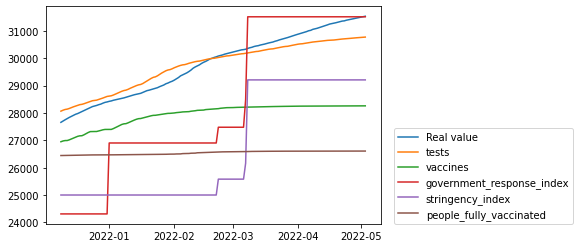

In [ ]:
plt.plot(x_test[['date']], y_test[['deaths']], label='Real value')
for col in top_5_deaths_scores['Independent column']:
  LR = LinearRegression()
  LR.fit(x_train[[col]], y_train[['deaths']])
  pred = LR.predict(x_test[[col]])
  plt.plot(x_test[['date']], pred, label=col)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

The variable that brings the best predictions, for dependent variable 'deaths', is 'tests'.

**Checking the homoscedasticity assumption for both linear regression models**

In [ ]:
LR_confirmed = LinearRegression()
LR_confirmed.fit(x_train[['economic_support_index']], y_train[['confirmed']])

LR_deaths = LinearRegression()
LR_deaths.fit(x_train[['tests']], y_train[['deaths']])

LinearRegression()

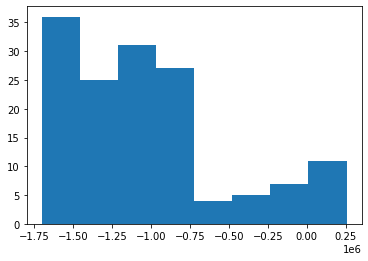

In [ ]:
residuals = LR_confirmed.predict(x_test[['economic_support_index']]) - y_test[['confirmed']]
bins = int(math.log(len(residuals), 2)) + 1
plt.hist(residuals.confirmed,bins=bins)
plt.show()


For linear model with independent variable 'economic_support_index' and dependent variable 'confirmed' homoscedasticity assumption is not present.

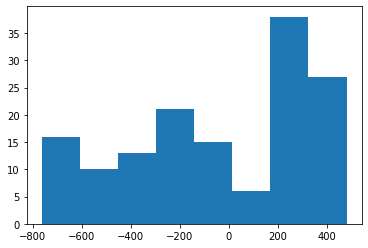

In [ ]:
residuals = LR_deaths.predict(x_test[['tests']]) - y_test[['deaths']]
bins = int(math.log(len(residuals), 2)) + 1
plt.hist(residuals.deaths,bins=bins)
plt.show()

For linear model with independent variable 'test' and dependent variable 'deaths' homoscedasticity assumption is also not present.

**Predicting the amount of confirmed for local data using multiple linear regression**

Using correlation matrix, checking the correlation between the best performing independent variables and dependent variable. At the same time checking whether independent variables are correlated with each other.

In [ ]:
corr_matrix = cb_after_vac[list(top_5_confirmed_scores['Independent column']) + ['confirmed']].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,economic_support_index,tests,government_response_index,vaccines,stringency_index,confirmed
economic_support_index,1.000000,-0.820544,0.829639,-0.722544,0.591473,-0.926515
tests,-0.820544,1.000000,-0.800595,0.973069,-0.775613,0.927961
government_response_index,0.829639,-0.800595,1.000000,-0.733564,0.903392,-0.887827
vaccines,-0.722544,0.973069,-0.733564,1.000000,-0.785197,0.837479
stringency_index,0.591473,-0.775613,0.903392,-0.785197,1.000000,-0.743824
confirmed,-0.926515,0.927961,-0.887827,0.837479,-0.743824,1.000000


Best candidates for multiple linear regression are: economic_support_index and stringency_index.

R2:  -1.540443004358519  MAPE:  0.33736792381910075


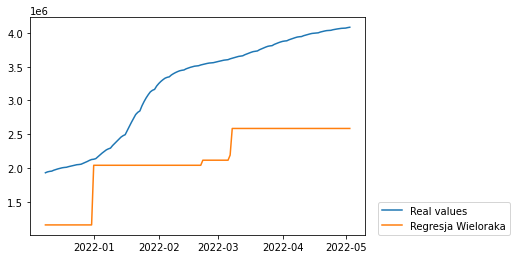

In [ ]:
MR_confirmed = LinearRegression()
MR_confirmed.fit(x_train[['economic_support_index','stringency_index']], y_train['confirmed'])
pred = MR_confirmed.predict(x_test[['economic_support_index','stringency_index']])
print("R2: ",str(r2_score(y_test[['confirmed']],pred))," MAPE: ",str(mean_absolute_percentage_error(y_test[['confirmed']],pred)))
plt.plot(x_test[['date']], y_test[['confirmed']], label='Real values')
plt.plot(x_test[['date']], pred, label='Multi linear regression')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

Created multiple linear regression model does not properly predict the amount of Covid-19 cases.

In case of the dependant variable 'confirmed', results for both linear and multiple linear regression models are not satisfactory.

**Predicting the amount of deaths for local data using multiple linear regression**

In [ ]:
corr_matrix = cb_after_vac[list(top_5_deaths_scores['Independent column']) + ['deaths']].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,tests,vaccines,government_response_index,stringency_index,people_fully_vaccinated,deaths
tests,1.000000,0.973069,-0.800595,-0.775613,0.895517,0.978907
vaccines,0.973069,1.000000,-0.733564,-0.785197,0.968069,0.943849
government_response_index,-0.800595,-0.733564,1.000000,0.903392,-0.617280,-0.800869
stringency_index,-0.775613,-0.785197,0.903392,1.000000,-0.744213,-0.787405
people_fully_vaccinated,0.895517,0.968069,-0.617280,-0.744213,1.000000,0.846779
deaths,0.978907,0.943849,-0.800869,-0.787405,0.846779,1.000000


Best candidates for multiple linear regression are: 'people_fully_vaccinated' and 'government_response_index'

R2:  -14.62222461370272  MAPE:  0.13779270205533786


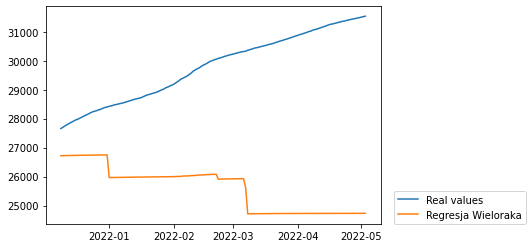

In [ ]:
MR_deaths = LinearRegression()
MR_deaths.fit(x_train[['people_fully_vaccinated','government_response_index']], y_train['deaths'])
pred = MR_deaths.predict(x_test[['people_fully_vaccinated','government_response_index']])
print("R2: ",str(r2_score(y_test[['deaths']],pred))," MAPE: ",str(mean_absolute_percentage_error(y_test[['deaths']],pred)))
plt.plot(x_test[['date']], y_test[['deaths']], label='Real values')
plt.plot(x_test[['date']], pred, label='Multiple linear regression')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

Multiple linear regression model does not bring satisfactory results.

In case of dependant variable 'deaths', the linear regression model has satisfactory R2 and MAPE values, but homoscedasticity assumption is not present, meaning it cannot be used. Multiple linear regression model does not work with the given data.

**Predicting the amount of confirmed cases for local data using other regression algoritms**

In [ ]:
SVR_confirmed = SVR()
SVR_confirmed.fit(x_train[['economic_support_index','stringency_index']], y_train['confirmed'])
pred_SVR = SVR_confirmed.predict(x_test[['economic_support_index','stringency_index']])
print("R2: ",str(r2_score(y_test[['confirmed']],pred_SVR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['confirmed']],pred_SVR)))

R2:  -8.643426546788445  MAPE:  0.6447303035118946


In [ ]:
DTR_confirmed = DecisionTreeRegressor()
DTR_confirmed.fit(x_train[['economic_support_index','stringency_index']], y_train['confirmed'])
pred_DTR = DTR_confirmed.predict(x_test[['economic_support_index','stringency_index']])
print("R2: ",str(r2_score(y_test[['confirmed']],pred_DTR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['confirmed']],pred_DTR)))

R2:  -6.422872670845502  MAPE:  0.4926572643676424


In [ ]:
RFR_confirmed = RandomForestRegressor()
RFR_confirmed.fit(x_train[['economic_support_index','stringency_index']], y_train['confirmed'])
pred_RFR = RFR_confirmed.predict(x_test[['economic_support_index','stringency_index']])
print("R2: ",str(r2_score(y_test[['confirmed']],pred_RFR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['confirmed']],pred_RFR)))

R2:  -6.428045802471455  MAPE:  0.4932592818061025


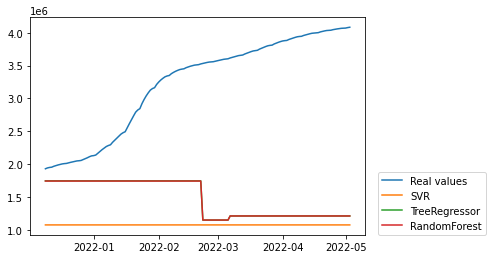

In [ ]:
plt.plot(x_test[['date']], y_test[['confirmed']], label='Real values')
plt.plot(x_test[['date']], pred_SVR, label='SVR')
plt.plot(x_test[['date']], pred_DTR, label='TreeRegressor')
plt.plot(x_test[['date']], pred_RFR, label='RandomForest')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

Comparing algorithms: SVR, Decision Tree and Random Forest for dependant variable 'confirmed', it is clear that none of them are suitable for predicting the amount of cases of Covid-19.

**Predicting the amount of deaths for local data using other regression algoritms**

In [ ]:
SVR_confirmed = SVR()
SVR_confirmed.fit(x_train[['people_fully_vaccinated','government_response_index']], y_train['deaths'])
pred_SVR = SVR_confirmed.predict(x_test[['people_fully_vaccinated','government_response_index']])
print("R2: ",str(r2_score(y_test[['deaths']],pred_SVR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['deaths']],pred_SVR)))

R2:  -14.246483106278928  MAPE:  0.14515499135743754


In [ ]:
DTR_confirmed = DecisionTreeRegressor()
DTR_confirmed.fit(x_train[['people_fully_vaccinated','government_response_index']], y_train['deaths'])
pred_DTR = DTR_confirmed.predict(x_test[['people_fully_vaccinated','government_response_index']])
print("R2: ",str(r2_score(y_test[['deaths']],pred_DTR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['deaths']],pred_DTR)))

R2:  -3.484559256801794  MAPE:  0.07102453093669725


In [ ]:
RFR_confirmed = RandomForestRegressor()
RFR_confirmed.fit(x_train[['people_fully_vaccinated','government_response_index']], y_train['deaths'])
pred_RFR = RFR_confirmed.predict(x_test[['people_fully_vaccinated','government_response_index']])
print("R2: ",str(r2_score(y_test[['deaths']],pred_RFR))," MAPE: ",str(mean_absolute_percentage_error(y_test[['deaths']],pred_RFR)))

R2:  -4.095869696242463  MAPE:  0.07646311395241147


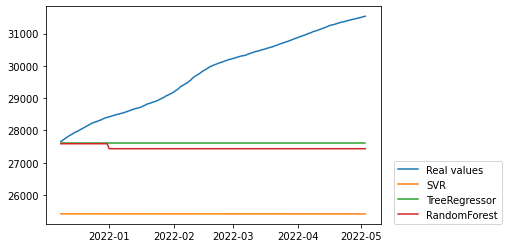

In [ ]:
plt.plot(x_test[['date']], y_test[['deaths']], label='Real values')
plt.plot(x_test[['date']], pred_SVR, label='SVR')
plt.plot(x_test[['date']], pred_DTR, label='TreeRegressor')
plt.plot(x_test[['date']], pred_RFR, label='RandomForest')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

Comparing again algorithms: SVR, Decision Tree and Random Forest for dependant variable 'deaths', it is clear that none of them are suitable for predicting the amount of deaths caused by Covid-19.

**GLOBAL DATA**

In [ ]:
covid_global, src = covid19() 

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


Deleting the same columns from global dataset as was done in local dataset

In [ ]:
covid_global = covid_global.drop(columns = ['recovered','id', 'administrative_area_level', 'administrative_area_level_1', 'administrative_area_level_2', 'administrative_area_level_3', 'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2', 'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm'])

Summing up all cases and deaths from each country by date.

In [ ]:
global_data = covid_global.groupby(['date'],as_index=False).sum()

Deleting data from the time before discovery of vaccines.

In [ ]:
global_data = global_data[global_data['vaccines'] != 0]

Deleting last five records, as data may have not been accumulated correctly yet.

In [ ]:
global_data = global_data.iloc[:-5]

In [ ]:
for col in global_data.columns:
    print(col,len(global_data[global_data[col] == 0]))

date 0
confirmed 0
deaths 0
tests 0
vaccines 0
people_vaccinated 0
people_fully_vaccinated 2
hosp 0
icu 0
vent 0
school_closing 0
workplace_closing 0
cancel_events 0
gatherings_restrictions 0
transport_closing 0
stay_home_restrictions 0
internal_movement_restrictions 8
international_movement_restrictions 0
information_campaigns 0
testing_policy 0
contact_tracing 0
facial_coverings 0
vaccination_policy 72
elderly_people_protection 0
government_response_index 0
stringency_index 0
containment_health_index 0
economic_support_index 0


Columns 'deaths' and 'confirmed' have no null values, so there is not need to delete empty rows this time.

In [ ]:
x_train_global, x_test_global, y_train_global, y_test_global = train_test_split(global_data[global_data.columns.difference(['confirmed', 'deaths'])],global_data[['confirmed', 'deaths']],test_size=0.3,shuffle=False)

**Predicting the amount of confirmed cases for global data using linear regression**

In [ ]:
confirmed_scores_global = []
for independent_column in x_train_global.columns.difference(['date']):
    print(independent_column,end=' ')
    LR = LinearRegression()
    LR.fit(x_train_global[[independent_column]], y_train_global[['confirmed']])
    pred = LR.predict(x_test_global[[independent_column]])
    confirmed_scores_global.append([independent_column,'confirmed',r2_score(y_test_global[['confirmed']],pred),mean_absolute_percentage_error(y_test_global[['confirmed']],pred)])

cancel_events contact_tracing containment_health_index economic_support_index elderly_people_protection facial_coverings gatherings_restrictions government_response_index hosp icu information_campaigns internal_movement_restrictions international_movement_restrictions people_fully_vaccinated people_vaccinated school_closing stay_home_restrictions stringency_index testing_policy tests transport_closing vaccination_policy vaccines vent workplace_closing 

In [ ]:
scores_global = pd.DataFrame(confirmed_scores_global,columns=['Independent column','Dependent column','r2','MAPE'])
top_5_confirmed_scores_global = scores_global.sort_values(by=["r2"],ascending=False).head(5)
print(top_5_confirmed_scores_global)

         Independent column Dependent column        r2      MAPE
3    economic_support_index        confirmed  0.685722  0.094185
22                 vaccines        confirmed  0.016601  0.163078
1           contact_tracing        confirmed -0.020299  0.157240
19                    tests        confirmed -0.061517  0.147830
13  people_fully_vaccinated        confirmed -0.087070  0.177903


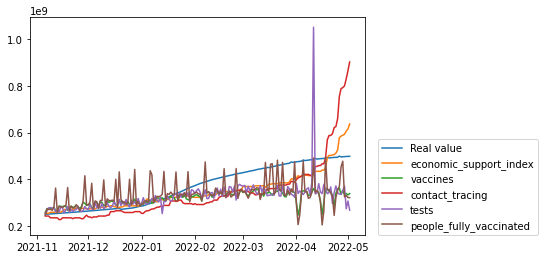

In [ ]:
plt.plot(x_test_global[['date']], y_test_global[['confirmed']], label='Real value')
for col in top_5_confirmed_scores_global['Independent column']:
  LR = LinearRegression()
  LR.fit(x_train_global[[col]], y_train_global[['confirmed']])
  pred = LR.predict(x_test_global[[col]])
  plt.plot(x_test_global[['date']], pred, label=col)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

As in the case of local data, the linear regression models do not predict confirmed cases of Covid-19 properly. Despite its R2 and MAPE values, independent variable 'economic_support_index' does not show correlation with real data on the plot.

**Predicting the amount of deaths for global data using linear regression**

In [ ]:
deaths_scores_global = []
for independent_column in x_train_global.columns.difference(['date']):
    print(independent_column,end=' ')
    LR = LinearRegression()
    LR.fit(x_train_global[[independent_column]], y_train_global[['deaths']])
    pred = LR.predict(x_test_global[[independent_column]])
    deaths_scores_global.append([independent_column,'deaths',r2_score(y_test_global[['deaths']],pred),mean_absolute_percentage_error(y_test_global[['deaths']],pred)])

cancel_events contact_tracing containment_health_index economic_support_index elderly_people_protection facial_coverings gatherings_restrictions government_response_index hosp icu information_campaigns internal_movement_restrictions international_movement_restrictions people_fully_vaccinated people_vaccinated school_closing stay_home_restrictions stringency_index testing_policy tests transport_closing vaccination_policy vaccines vent workplace_closing 

In [ ]:
scores_global = pd.DataFrame(deaths_scores_global,columns=['Independent column','Dependent column','r2','MAPE'])
top_5_deaths_scores_global = scores_global.sort_values(by=["r2"],ascending=False).head(5)
print(top_5_deaths_scores_global)

                     Independent column Dependent column         r2      MAPE
14                    people_vaccinated           deaths -14.916446  0.126783
21                   vaccination_policy           deaths -15.082906  0.134766
22                             vaccines           deaths -20.721459  0.191186
12  international_movement_restrictions           deaths -39.631635  0.223614
15                       school_closing           deaths -40.836038  0.274112


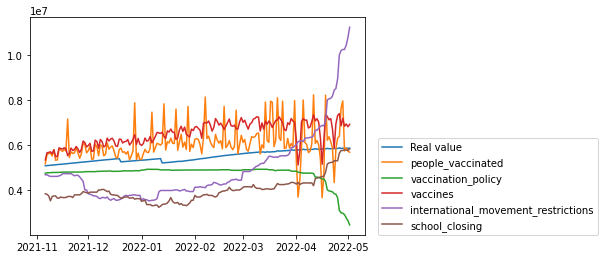

In [ ]:
plt.plot(x_test_global[['date']], y_test_global[['deaths']], label='Real value')
for col in top_5_deaths_scores_global['Independent column']:
  LR = LinearRegression()
  LR.fit(x_train_global[[col]], y_train_global[['deaths']])
  pred = LR.predict(x_test_global[[col]])
  plt.plot(x_test_global[['date']], pred, label=col)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

None of the models predict the amount of deaths in global scale properly.

**Checking the homoscedasticity assumption for both linear regression models**

In [ ]:
LR_confirmed_global = LinearRegression()
LR_confirmed_global.fit(x_train_global[['economic_support_index']], y_train_global[['confirmed']])

LR_deaths_global = LinearRegression()
LR_deaths_global.fit(x_train_global[['vaccination_policy']], y_train_global[['deaths']])

LinearRegression()

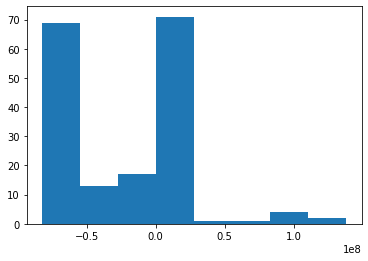

In [ ]:
residuals = LR_confirmed_global.predict(x_test_global[['economic_support_index']]) - y_test_global[['confirmed']]
bins = int(math.log(len(residuals), 2)) + 1
plt.hist(residuals.confirmed,bins=bins)
plt.show()

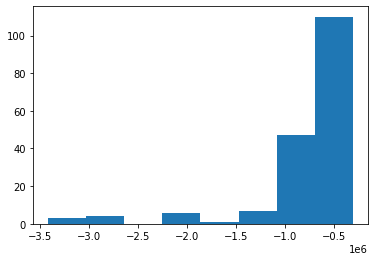

In [ ]:
residuals = LR_deaths_global.predict(x_test_global[['vaccination_policy']]) - y_test_global[['deaths']]
bins = int(math.log(len(residuals), 2)) + 1
plt.hist(residuals.deaths,bins=bins)
plt.show()

In neither of the linear models the homoscedasticity assumption is present, meaning they cannot be used for prediction.

**Predicting the amount of confirmed cases for global data using multiple linear regression**

In [ ]:
corr_matrix = global_data[list(top_5_confirmed_scores_global['Independent column']) + ['confirmed']].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,economic_support_index,vaccines,contact_tracing,tests,people_fully_vaccinated,confirmed
economic_support_index,1.000000,-0.934827,0.956543,-0.912641,-0.898673,-0.976142
vaccines,-0.934827,1.000000,-0.834155,0.940086,0.962470,0.936884
contact_tracing,0.956543,-0.834155,1.000000,-0.819576,-0.797221,-0.920642
tests,-0.912641,0.940086,-0.819576,1.000000,0.912282,0.931915
people_fully_vaccinated,-0.898673,0.962470,-0.797221,0.912282,1.000000,0.901403
confirmed,-0.976142,0.936884,-0.920642,0.931915,0.901403,1.000000


Best candidates for multiple linear regression are: 'economic_support_index' and 'contact_tracing'

R2:  0.5318769553192163  MAPE:  0.0948354827240678


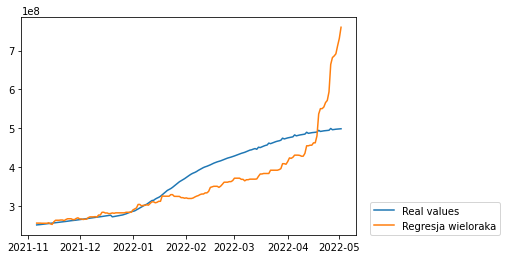

In [ ]:
MR_confirmed_global = LinearRegression()
MR_confirmed_global.fit(x_train_global[['economic_support_index','contact_tracing']], y_train_global['confirmed'])
pred = MR_confirmed_global.predict(x_test_global[['economic_support_index','contact_tracing']])
print("R2: ",str(r2_score(y_test_global[['confirmed']],pred))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['confirmed']],pred)))
plt.plot(x_test_global[['date']], y_test_global[['confirmed']], label='Real values')
plt.plot(x_test_global[['date']], pred, label='Regresja wieloraka')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

In case of the global data, the multiple regression model is far better that the regular linear regression one. Saying that, it does not fit the data correctly the further it goes.

**Predicting the amount of deaths for global data using multiple linear regression**

In [ ]:
corr_matrix = global_data[list(top_5_deaths_scores_global['Independent column']) + ['deaths']].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,people_vaccinated,vaccination_policy,vaccines,international_movement_restrictions,school_closing,deaths
people_vaccinated,1.000000,0.868751,0.975853,-0.712293,-0.653704,0.933126
vaccination_policy,0.868751,1.000000,0.854140,-0.483785,-0.724622,0.953314
vaccines,0.975853,0.854140,1.000000,-0.755155,-0.655720,0.940556
international_movement_restrictions,-0.712293,-0.483785,-0.755155,1.000000,0.688927,-0.697646
school_closing,-0.653704,-0.724622,-0.655720,0.688927,1.000000,-0.784993
deaths,0.933126,0.953314,0.940556,-0.697646,-0.784993,1.000000


Best candidates for multiple linear regression are: 'vaccination_policy' and 'international_movement_restrictions'

R2:  -4.641867117624046  MAPE:  0.08879443943735045


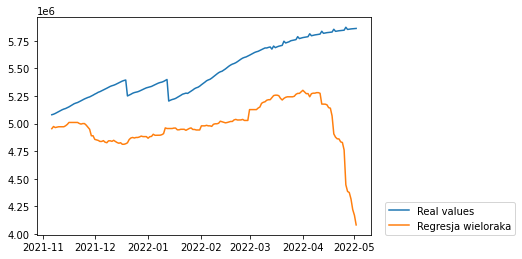

In [ ]:
MR_deaths_global = LinearRegression()
MR_deaths_global.fit(x_train_global[['vaccination_policy','international_movement_restrictions']], y_train_global['deaths'])
pred = MR_deaths_global.predict(x_test_global[['vaccination_policy','international_movement_restrictions']])
print("R2: ",str(r2_score(y_test_global[['deaths']],pred))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['deaths']],pred)))
plt.plot(x_test_global[['date']], y_test_global[['deaths']], label='Real values')
plt.plot(x_test_global[['date']], pred, label='Regresja wieloraka')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

In case of global data, both multiple linear regression and linear regression are not suitable for predicting the amount of deaths caused by Covid-19.

**Predicting the amount of confirmed cases for global data using other regression algoritms**

In [ ]:
SVR_confirmed_global = SVR()
SVR_confirmed_global.fit(x_train_global[['economic_support_index','contact_tracing']], y_train_global['confirmed'])
pred_SVR = SVR_confirmed_global.predict(x_test_global[['economic_support_index','contact_tracing']])
print("R2: ",str(r2_score(y_test_global[['confirmed']],pred_SVR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['confirmed']],pred_SVR)))

R2:  -6.896793248459243  MAPE:  0.6060216525551676


In [ ]:
DTR_confirmed_global = DecisionTreeRegressor()
DTR_confirmed_global.fit(x_train_global[['economic_support_index','contact_tracing']], y_train_global['confirmed'])
pred_DTR = DTR_confirmed_global.predict(x_test_global[['economic_support_index','contact_tracing']])
print("R2: ",str(r2_score(y_test_global[['confirmed']],pred_DTR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['confirmed']],pred_DTR)))

R2:  -1.8890045419144474  MAPE:  0.28752214049288616


In [ ]:
RFR_confirmed_global = RandomForestRegressor()
RFR_confirmed_global.fit(x_train_global[['economic_support_index','contact_tracing']], y_train_global['confirmed'])
pred_RFR = RFR_confirmed_global.predict(x_test_global[['economic_support_index','contact_tracing']])
print("R2: ",str(r2_score(y_test_global[['confirmed']],pred_RFR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['confirmed']],pred_RFR)))

R2:  -1.8723604655765738  MAPE:  0.2862877597501258


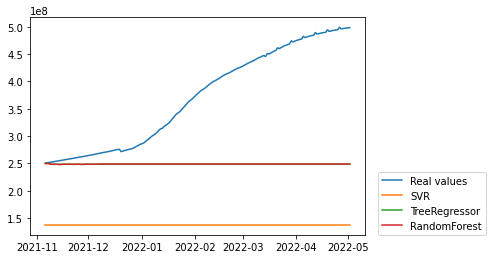

In [ ]:
plt.plot(x_test_global[['date']], y_test_global[['confirmed']], label='Real values')
plt.plot(x_test_global[['date']], pred_SVR, label='SVR')
plt.plot(x_test_global[['date']], pred_DTR, label='TreeRegressor')
plt.plot(x_test_global[['date']], pred_RFR, label='RandomForest')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

None of the algorithms worked properly with the global data. None of them is able to predict global confirmed cases.

**Predicting the amount of deaths for global data using other regression algoritms**

In [ ]:
SVR_confirmed_global = SVR()
SVR_confirmed_global.fit(x_train_global[['vaccination_policy','international_movement_restrictions']], y_train_global['deaths'])
pred_SVR = SVR_confirmed_global.predict(x_test_global[['vaccination_policy','international_movement_restrictions']])
print("R2: ",str(r2_score(y_test_global[['deaths']],pred_SVR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['deaths']],pred_SVR)))

R2:  -110.4856452433396  MAPE:  0.4562966020970232


In [ ]:
DTR_confirmed_global = DecisionTreeRegressor()
DTR_confirmed_global.fit(x_train_global[['vaccination_policy','international_movement_restrictions']], y_train_global['deaths'])
pred_DTR = DTR_confirmed_global.predict(x_test_global[['vaccination_policy','international_movement_restrictions']])
print("R2: ",str(r2_score(y_test_global[['deaths']],pred_DTR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['deaths']],pred_DTR)))

R2:  -13.27492562849901  MAPE:  0.11524089736498479


In [ ]:
RFR_confirmed_global = RandomForestRegressor()
RFR_confirmed_global.fit(x_train_global[['vaccination_policy','international_movement_restrictions']], y_train_global['deaths'])
pred_RFR = RFR_confirmed_global.predict(x_test_global[['vaccination_policy','international_movement_restrictions']])
print("R2: ",str(r2_score(y_test_global[['deaths']],pred_RFR))," MAPE: ",str(mean_absolute_percentage_error(y_test_global[['deaths']],pred_RFR)))

R2:  -13.296252929531443  MAPE:  0.1196614522288455


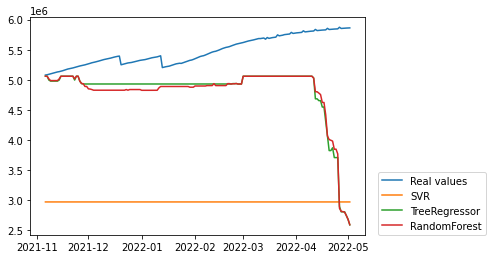

In [ ]:
plt.plot(x_test_global[['date']], y_test_global[['deaths']], label='Real values')
plt.plot(x_test_global[['date']], pred_SVR, label='SVR')
plt.plot(x_test_global[['date']], pred_DTR, label='TreeRegressor')
plt.plot(x_test_global[['date']], pred_RFR, label='RandomForest')
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.show()

None of the models predict the amount of deaths properly. Used algorithms are not suitable for this type of problem.

**In summary**

Regression algorithms are not suitable for this type of issue. Trying to predict the amounts of confirmed cases or deaths caused by Covid-19, brings no useful data. It is difficult to compare the used algorithms and say which one is the best, as all of them failed in either the R2 and MAPA scores or the homoscedasticity assumption was not present.